# Modeling the Hourly Rate

This code trains a model to predict what a prospective freelancers hourly rate should be. The model used is a random forest regression model. I also built an AdaBoosted Decision Tree model, but it performs much worse (using 5-fold cross-validation) compared with the turned random forest regression model.

I've also built a k-modes (cluster with categorical/numeric mixed data) model. It is currently being tested.

# Prep

## Importing Libraries and Data

In [1]:
# Data Analysis and Modeling
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# AdaBoost Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# LASSO
from sklearn.linear_model import LassoCV, Lasso

# XGBoost
import xgboost as xgb

# Cross-Validation and Accuracy Measures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

# Model Serializing (export to web-app)
import pickle

# Packages for PostgreSQL Import
import psycopg2
import os

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

## Importing Data from SQL

In [28]:
# Names for accessing SQL database
dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

# Connect to SQL Database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Importing Data
sql_query = """SELECT * FROM analysis_dummies_table;"""
analysis_dt = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * FROM embeddings_table;"""
embeddings = pd.read_sql_query(sql_query, con)

# Doing some cleaning. Removing columns that have a continuous analog in the model.
analysis_dt = analysis_dt.drop(['index'], axis=1)
analysis_dt = analysis_dt.drop(['first_skill'], axis = 1)

# Removing index col from embeddings
embeddings = embeddings.drop(['index'], axis = 1)

# Merging on profile_url
analysis_dt = analysis_dt.merge(embeddings, how = "left", 
                                left_on = "profile_url", right_on= "profile_url")
profile_url = analysis_dt['profile_url']
analysis_dt = analysis_dt.drop(['profile_url'], axis = 1)
analysis_dt = analysis_dt.fillna(0)

# Cleaning avg_word_length and bio_word count
analysis_dt.loc[analysis_dt['bio_length'] == 0, ['bio_word_count','avg_word_length']] = 0

# Removing inactive users
analysis_dt = analysis_dt.loc[analysis_dt['has_quote'] == 1, :]
analysis_dt.shape

# Removing crazy outliers
analysis_dt = analysis_dt.loc[analysis_dt['hourly_rate'] < 100, :]

# Final Cleaning
analysis_dt = analysis_dt.drop(['num_skills','earnings_per_month',
                                'hours_worked', 'worked_pst_yr',
                                'hours_worked_pr_mnth','has_quote'], axis = 1)
# analysis_dt = analysis_dt.drop(['hours_worked_pr_mnth_pst_yr'], axis = 1)
# analysis_dt = analysis_dt.drop(analysis_dt.columns[15:65], axis = 1)

# Last check
analysis_dt.shape

(369, 115)

## Prepping Data for Training

In [59]:
# Converting data to numpy arrays and saving column names
y = analysis_dt['hourly_rate']

dt = analysis_dt.drop(['hourly_rate'], axis = 1)
feature_list = list(dt.columns)

X = dt

In [60]:
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Modeling - XGBoost

In [31]:
# Convert Data into DMatrix
dtest = xgb.DMatrix(np.array(X_test), label=np.array(y_test))
dtrain = xgb.DMatrix(np.array(X_train), label= np.array(y_train))
dtrain.save_binary((os.environ['PWD'] + '/data/cleaned/train.buffer'))
dtest.save_binary((os.environ['PWD'] + '/data/cleaned/test.buffer'))

In [32]:
# Baseline Model without Tuning
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric': "mae"
}

num_boost_round = 999

# Cross-Validated XGBoost
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

# MAE With Default Params = 17.60

[0]	Test-mae:21.95933
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:18.11282
[2]	Test-mae:16.93211
[3]	Test-mae:15.76214
[4]	Test-mae:15.67782
[5]	Test-mae:15.72561
[6]	Test-mae:15.66180
[7]	Test-mae:15.48387
[8]	Test-mae:15.72361
[9]	Test-mae:15.91339
[10]	Test-mae:16.22735
[11]	Test-mae:16.26434
[12]	Test-mae:16.27698
[13]	Test-mae:16.23676
[14]	Test-mae:16.23555
[15]	Test-mae:16.20380
[16]	Test-mae:16.17112
[17]	Test-mae:16.22702
Stopping. Best iteration:
[7]	Test-mae:15.48387



In [33]:
# Reference: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2, 20, 2)
    for min_child_weight in range(2, 20, 2)
]

min_mae = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
        max_depth,
        min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=2, min_child_weight=2
	MAE 13.9241584 for 5 rounds
CV with max_depth=2, min_child_weight=4
	MAE 13.985680400000001 for 7 rounds
CV with max_depth=2, min_child_weight=6
	MAE 13.913796 for 6 rounds
CV with max_depth=2, min_child_weight=8
	MAE 13.810689799999997 for 6 rounds
CV with max_depth=2, min_child_weight=10
	MAE 13.817743400000001 for 6 rounds
CV with max_depth=2, min_child_weight=12
	MAE 13.844184799999999 for 10 rounds
CV with max_depth=2, min_child_weight=14
	MAE 13.9189666 for 5 rounds
CV with max_depth=2, min_child_weight=16
	MAE 13.99769 for 5 rounds
CV with max_depth=2, min_child_weight=18
	MAE 13.9206282 for 5 rounds
CV with max_depth=4, min_child_weight=2
	MAE 13.9902376 for 5 rounds
CV with max_depth=4, min_child_weight=4
	MAE 13.9439774 for 5 rounds
CV with max_depth=4, min_child_weight=6
	MAE 13.9917816 for 5 rounds
CV with max_depth=4, min_child_weight=8
	MAE 13.671137400000001 for 5 rounds
CV with max_depth=4, min_child_weight=10
	MAE 13.72799579999

In [34]:
# Updating params dictionary with selected values
params['max_depth'] = 4
params['min_child_weight'] = 8

In [35]:
# Tuning subsample and colsample_bytree
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(1,11)]
]

min_mae = float("Inf")
best_params = None# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

CV with subsample=1.0, colsample=1.0
	MAE 13.6711372 for 5 rounds
CV with subsample=1.0, colsample=0.9
	MAE 13.452415199999999 for 6 rounds
CV with subsample=1.0, colsample=0.8
	MAE 13.283531199999999 for 5 rounds
CV with subsample=1.0, colsample=0.7
	MAE 13.865132400000002 for 6 rounds
CV with subsample=1.0, colsample=0.6
	MAE 13.8214262 for 7 rounds
CV with subsample=1.0, colsample=0.5
	MAE 13.921607 for 7 rounds
CV with subsample=1.0, colsample=0.4
	MAE 14.252475 for 9 rounds
CV with subsample=1.0, colsample=0.3
	MAE 14.6360738 for 20 rounds
CV with subsample=1.0, colsample=0.2
	MAE 14.837176199999998 for 4 rounds
CV with subsample=1.0, colsample=0.1
	MAE 15.190624 for 4 rounds
CV with subsample=0.9, colsample=1.0
	MAE 13.720952399999998 for 5 rounds
CV with subsample=0.9, colsample=0.9
	MAE 13.780568399999998 for 4 rounds
CV with subsample=0.9, colsample=0.8
	MAE 13.886528000000002 for 5 rounds
CV with subsample=0.9, colsample=0.7
	MAE 13.663871799999999 for 7 rounds
CV with subsam

In [36]:
# Tuning ETA (learning rate)
min_mae = float("Inf")
best_params = None

for eta in [.3, .2, .1, .07, .05, .02, .01, .005]:
    print("CV with eta={}".format(eta))    # We update our parameters
    params['eta'] = eta    # Run and time CV
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['mae'],
        early_stopping_rounds=10
    )    # Update best score
    
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['eta'] = best_params

CV with eta=0.3
	MAE 13.283531 for 5 rounds

CV with eta=0.2
	MAE 13.5574164 for 9 rounds

CV with eta=0.1
	MAE 13.6357612 for 22 rounds

CV with eta=0.07
	MAE 13.6796368 for 28 rounds

CV with eta=0.05
	MAE 13.67466 for 50 rounds

CV with eta=0.02
	MAE 13.71827 for 102 rounds

CV with eta=0.01
	MAE 13.713700399999999 for 194 rounds

CV with eta=0.005
	MAE 13.735285999999999 for 384 rounds

Best params: 0.3, MAE: 13.283531


In [37]:
# Train Final Model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:21.45451
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:18.39790
[2]	Test-mae:16.90287
[3]	Test-mae:16.06467
[4]	Test-mae:15.68448
[5]	Test-mae:15.84417
[6]	Test-mae:16.07134
[7]	Test-mae:16.28778
[8]	Test-mae:16.38888
[9]	Test-mae:16.44014
[10]	Test-mae:16.47882
[11]	Test-mae:16.61021
[12]	Test-mae:16.73468
[13]	Test-mae:16.34522
[14]	Test-mae:16.34710
Stopping. Best iteration:
[4]	Test-mae:15.68448

Best MAE: 15.68 in 5 rounds


In [38]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:21.45451
[1]	Test-mae:18.39790
[2]	Test-mae:16.90287
[3]	Test-mae:16.06467
[4]	Test-mae:15.68448


In [39]:
# Exporting model
filename = os.environ['PWD'] + '/scripts/models/model_xgb_v4.model'
# filename_dump = os.environ['PWD'] + '/scripts/models/dump.raw.txt'

best_model.save_model(filename)
# best_model.dump_model(filename_dump)

# Modeling - LASSO

In [40]:
# Running model
model_lasso = LassoCV(cv=20).fit(X_train, y_train)

# Saving model with pickle
filename = os.environ['PWD'] + '/scripts/models/model_lasso.sav'
pickle.dump(model_lasso, open(filename, 'wb'))

# Modeling - Random Forest Regression
## Estimating a Random Forest Regression to Estimate Hourly-Rate

Notes:
    - Next model probability of getting a job?
    - Convert to a clustering algorithm and present a range of estimates?
    - Bootstrap to get a range of estimates?
    - Make suggestions (Increase bio length by 10 and you can charge X more)
        - "Here are bios for users similar to you" etc. etc.
    - Focus on helping users build up their profiles

In [41]:
# References for GridSearchCV
# 1 - https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters
# 2 - https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
# References for Random Forest Regression
# 1 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# 2 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Creating parameter grid
parameters = {"max_features": ["auto", "sqrt"], 
              "n_estimators": [100, 500, 900, 1300, 1500], 
              "max_depth": [None,5,10,20]}

# Creating Grid Search Class
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4, verbose=True, 
                   scoring="neg_mean_absolute_error",
                   refit=True, cv = 3)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_rfr = clf.best_estimator_

# Printing results
print(round(clf.best_score_,2), clf.best_params_)

# Exporting model
filename = os.environ['PWD'] + '/scripts/models/model_rfr.sav'
pickle.dump(model_rfr, open(filename, 'wb'))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  2.2min finished


-14.22 {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}


# Fitting AdaBoost Model
The reason to fit this model is that iteratively re-weights observations based on how poorly the model predicts them. This pushes the model to finding a way to predict observations other models may miss. I am concerned, however, if it will overfit to outliers.

It performs poorly compared to the random forest regression.

In [42]:
# Creating parameter grid
parameters = {"n_estimators": [1, 3, 5, 10, 25, 50, 75, 100, 125, 150],
              "base_estimator__max_depth": [3, 5, 7, 9, 10, 11]}

regr_1 = DecisionTreeRegressor()
regr_2 = AdaBoostRegressor(base_estimator=regr_1)

# Creating Grid Search Class
clf = GridSearchCV(regr_2, parameters, n_jobs=4, verbose=True)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_ada = clf.best_estimator_

# Printing results
print(round(clf.best_score_, 2), clf.best_params_)

# Exporting Model
filename = os.environ['PWD'] + '/scripts/models/model_ada.sav'
pickle.dump(model_ada, open(filename, 'wb'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 116 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 272 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   36.2s finished


0.15 {'base_estimator__max_depth': 7, 'n_estimators': 125}


# Model Evaluation

## Functions for Evaluation

In [43]:
def baseline_performance(outcome_data, test_data):
    # Assumes training the mean
    
    # Getting Baseline
    baseline_preds = np.mean(outcome_data)

    # Baseline Errors
    baseline_errors = abs(baseline_preds - test_data)

    # Baseline:
    print('Baseline Performance of Naive Mean Estimator:\nMean Absolute Error:', round(np.mean(baseline_errors), 2))
    
    return np.mean(baseline_errors)
    
def model_performance(predictions, outcome_data, baseline, model_str_name):
    # Calculate absolute error (comparison with baseline)
    errors = abs(predictions - outcome_data)
    
    print(model_str_name + ' Performance:')
    
    # Print out the mean absolute error (mae)
    print('\tMean absolute error: %.2f'
          % mean_absolute_error(outcome_data, predictions))

    # The mean squared error
    print('\tMean squared error: %.2f'
          % mean_squared_error(outcome_data, predictions))

    # The coefficient of determination (R2)
    print('\tCoefficient of determination: %.2f'
          % r2_score(outcome_data, predictions))

    # Does much better than the mean with regard to mean absolute error
    print("\tA ", round((np.mean(errors)-baseline)/baseline,3)*-100,
          "percent change over the mean")
    
    # What is the average dollar change in user hourly rate with this model?
    print("\tAverage Change in Hourly Rate vs Naive Model: $", np.mean(predictions - baseline))

def plot_preds_truth(x, y):
    # Calculate Error
    error = abs(x-y)
    
    # Plotting True Hourly Rates vs Predicted Hourly Rates
    sns.scatterplot(x = x, y = y, palette=['orange'])
    sns.lineplot(x = list(range(0,101)), y = list(range(0,101)), palette=['red'])
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()
    
# Aggregate Function: Model_performance
def model_evaluation(model, model_name_string):

    if model_name_string == 'XGBoost':
        
        # Converting data to useable format 
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Evaluating Model
        model_performance(model.predict(dtest), y_test, pred_baseline, 'model_name_string')

        # Plotting True Hourly Rates vs Predicted Hourly Rates
        plot_preds_truth(x = y_test, y = model.predict(dtest))
        
    else:
        
        # Evaluating Model
        model_performance(model.predict(X_test), y_test, pred_baseline, 'model_name')

        # Plotting True Hourly Rates vs Predicted Hourly Rates
        plot_preds_truth(x = y_test, y = model.predict(X_test))


## Loading Models

In [44]:
# XGBoost
model_xgboost = xgb.Booster({'nthread': 4})  # init model
model_xgboost.load_model(os.environ['PWD'] + '/scripts/models/model_xgb_v4.model')  # load data

# Lasso
filename = os.environ['PWD'] + '/scripts/models/model_lasso.sav'
model_lasso = pickle.load(open(filename, 'rb'))

# Random Forest Regression
filename = os.environ['PWD'] + '/scripts/models/model_rfr.sav'
model_rfr = pickle.load(open(filename, 'rb'))

# AdaBoost
filename = os.environ['PWD'] + '/scripts/models/model_ada.sav'
model_ada = pickle.load(open(filename, 'rb'))

## Evaluation

Baseline Performance of Naive Mean Estimator:
Mean Absolute Error: 16.81


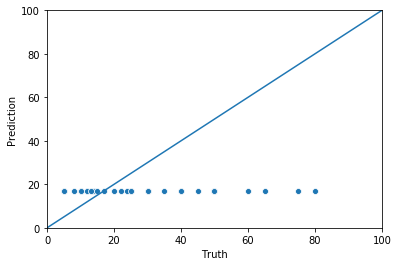

In [45]:
pred_baseline = baseline_performance(y_train, y_test)
plot_preds_truth(x = y_test, y = pred_baseline)

model_name_string Performance:
	Mean absolute error: 15.68
	Mean squared error: 439.34
	Coefficient of determination: -0.07
	A  6.7 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 5.542626


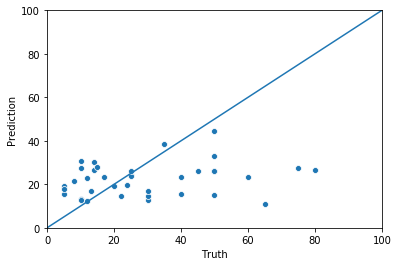

In [46]:
# XGBoost
model_evaluation(model_xgboost, 'XGBoost')

model_name Performance:
	Mean absolute error: 19.42
	Mean squared error: 610.13
	Coefficient of determination: -0.49
	A  -15.5 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 9.728042162009247


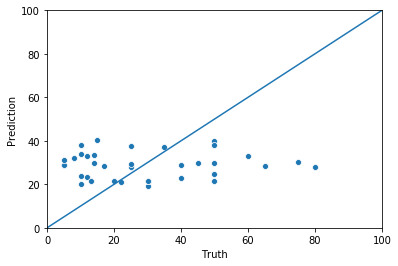

In [47]:
# Lasso
model_evaluation(model_lasso, 'LASSO')

model_name Performance:
	Mean absolute error: 16.39
	Mean squared error: 407.40
	Coefficient of determination: 0.01
	A  2.5 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 9.308128654836633


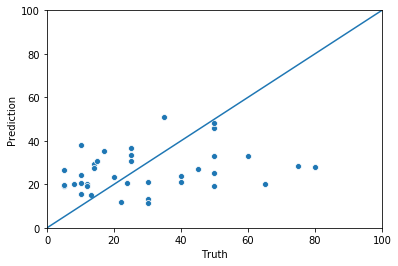

In [48]:
# Random Forest
model_evaluation(model_rfr, 'Random Forest Regression')

model_name Performance:
	Mean absolute error: 15.39
	Mean squared error: 362.30
	Coefficient of determination: 0.12
	A  8.4 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 9.14618499148077


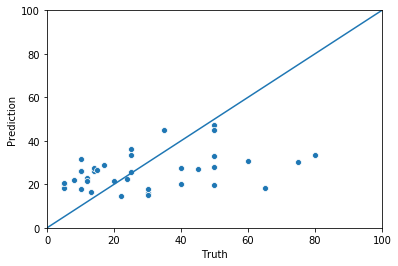

In [61]:
# AdaBoost
model_evaluation(model_ada, 'AdaBoosted Regression Trees')

# Investigating the edge cases

For those with low truth hourly rates, were they just under pricing themselves? Is my model finding that and recommending their real, competitive, hourly rate?

In [ ]:
# Getting predicted values
X_test['preds'] = model_ada.predict(X_test)

In [63]:
# Merging into Data
dt = analysis_dt.merge(X_test['preds'], how = 'left', left_index=True, right_index=True)
dt['profile_url'] = profile_url
dt['error'] = dt['preds'] - dt['hourly_rate']

In [70]:
# Investigating people for whom the predicted was ~ 20 and the truth was ~ 5
display(dt.loc[(dt['error'] > 10), ['profile_url','hourly_rate','preds','error']])
display(dt[(dt['error'] > 15)].profile_url.tolist())

# Largely, these seem to be people who are underpricing themselves relative to the rest of the market

,profile_url,hourly_rate,preds,error
16,https://www.guru.com/freelancers/mxi-coders-inc,14.0,27.346154,13.346154
83,https://www.guru.com/freelancers/deinde-engine...,15.0,26.428571,11.428571
122,https://www.guru.com/freelancers/rfadera,10.0,26.279412,16.279412
214,https://www.guru.com/freelancers/peavyassociate,14.0,26.062500,12.062500
246,https://www.guru.com/freelancers/technocad3d,25.0,36.250000,11.250000
264,https://www.guru.com/freelancers/barbara-vargas,5.0,20.000000,15.000000
362,https://www.guru.com/freelancers/amale,5.0,18.441860,13.441860
436,https://www.guru.com/freelancers/gabriel-mendoza,10.0,31.666667,21.666667
437,https://www.guru.com/freelancers/bplanningcom,5.0,20.625000,15.625000
527,https://www.guru.com/freelancers/harris-janoo,8.0,21.935484,13.935484


['https://www.guru.com/freelancers/rfadera',
 'https://www.guru.com/freelancers/gabriel-mendoza',
 'https://www.guru.com/freelancers/bplanningcom',
 'https://www.guru.com/freelancers/alexis-leigh']

In [73]:
# Investigating people for whom the ground truth > 60 but predicted is ~30
display(dt.loc[(dt['error'] < -15), ['profile_url','hourly_rate','preds','error']])
display(dt[(dt['error'] < -15)].profile_url.tolist())

,profile_url,hourly_rate,preds,error
44,https://www.guru.com/freelancers/icemen,65.0,18.463415,-46.536585
76,https://www.guru.com/freelancers/a1-digital-so...,60.0,30.866667,-29.133333
139,https://www.guru.com/freelancers/the-quirky-cr...,50.0,19.611111,-30.388889
314,https://www.guru.com/freelancers/carolyn-fleming,40.0,20.200000,-19.800000
359,https://www.guru.com/freelancers/big-whiskey-d...,45.0,27.000000,-18.000000
524,https://www.guru.com/freelancers/michael-brand,80.0,33.600000,-46.400000
650,https://www.guru.com/freelancers/robert-wooldr...,50.0,32.964286,-17.035714
764,https://www.guru.com/freelancers/procutsediting,50.0,27.928571,-22.071429
796,https://www.guru.com/freelancers/bricasso,75.0,30.481481,-44.518519


['https://www.guru.com/freelancers/icemen',
 'https://www.guru.com/freelancers/a1-digital-solutions-inc',
 'https://www.guru.com/freelancers/the-quirky-creative',
 'https://www.guru.com/freelancers/carolyn-fleming',
 'https://www.guru.com/freelancers/big-whiskey-design-studio',
 'https://www.guru.com/freelancers/michael-brand',
 'https://www.guru.com/freelancers/robert-wooldridge',
 'https://www.guru.com/freelancers/procutsediting',
 'https://www.guru.com/freelancers/bricasso']

In [75]:
# Investigating people for whom the ground truth > 40 and the model does well on
display(dt.loc[(dt['error'] < 10) & (dt['hourly_rate'] > 40), ['profile_url','hourly_rate','preds','error']])
display(dt[(dt['error'] < 10) & (dt['hourly_rate'] > 40)].profile_url.tolist())

,profile_url,hourly_rate,preds,error
44,https://www.guru.com/freelancers/icemen,65.0,18.463415,-46.536585
76,https://www.guru.com/freelancers/a1-digital-so...,60.0,30.866667,-29.133333
139,https://www.guru.com/freelancers/the-quirky-cr...,50.0,19.611111,-30.388889
359,https://www.guru.com/freelancers/big-whiskey-d...,45.0,27.000000,-18.000000
524,https://www.guru.com/freelancers/michael-brand,80.0,33.600000,-46.400000
650,https://www.guru.com/freelancers/robert-wooldr...,50.0,32.964286,-17.035714
712,https://www.guru.com/freelancers/brian-zifac,50.0,47.075000,-2.925000
764,https://www.guru.com/freelancers/procutsediting,50.0,27.928571,-22.071429
796,https://www.guru.com/freelancers/bricasso,75.0,30.481481,-44.518519
864,https://www.guru.com/freelancers/gemini-writin...,50.0,44.750000,-5.250000


['https://www.guru.com/freelancers/icemen',
 'https://www.guru.com/freelancers/a1-digital-solutions-inc',
 'https://www.guru.com/freelancers/the-quirky-creative',
 'https://www.guru.com/freelancers/big-whiskey-design-studio',
 'https://www.guru.com/freelancers/michael-brand',
 'https://www.guru.com/freelancers/robert-wooldridge',
 'https://www.guru.com/freelancers/brian-zifac',
 'https://www.guru.com/freelancers/procutsediting',
 'https://www.guru.com/freelancers/bricasso',
 'https://www.guru.com/freelancers/gemini-writing-services']